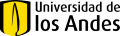

<span style="font-family:Cambria Math">
    
# Micro-proyecto 1. Generación de paleta de colores a partir de imágenes con técnicas de *machine learning* no supervisado

## Contexto
Este proyecto busca desarrollar una aplicación basada en *machine learning* que permita generar automáticamente paletas de colores a partir de imágenes. Esta herramienta ayudará a diseñadores, artistas y creadores de contenido a seleccionar combinaciones cromáticas armoniosas y funcionales de manera rápida y eficiente. La aplicación identificará los tonos dominantes y analizará sus relaciones cromáticas para crear paletas visualmente atractivas, optimizando la calidad y el impacto de la comunicación visual en diversos campos como el diseño, el arte, la psicología y el marketing.

***

También este micro-proyecto busca retar a los estudiantes para aplicar los conocimientos adquiridos en las semanas 1-4 del curso "*Machine Learning* No Supervisado".

***

## Objetivo
Desarrollar un método, basado en técnicas de agrupación, que permita extraer los tonos de
una imagen y generar un muestrario de los colores presentes en esta
</span>

***

<div class="alert alert-block alert-info">
<bNotar:</b >

**Este proyecto es realizado por Andrés Felipe Ñungo y Jordan Núñez Campos para entrega el 24 de febrero.**
</div24></span>

***

<div class="alert alert-block alert-info">
<bNotar:</b >

**1. Utilizar la heurística para encontrar los mejores epsilon y min samples** , Pensar en usar HDBSCAN y Índice DBCV (Density-based Clustering Validation):(Responsable: Andrés) Check

**2.Visualización t-SNE** (Responsable: Andrés, hablarlo con los monitores, profesora) Check

**3. Implementar Aglomerativo** (Responsable: Jordan)

**4. Visualización de las siluetas** (Responsable: Jordan)

**5. Descripciones, textos, justificaciones** (Responsable: Jordan, Andrés)


</div24></span>

***

<span style="font-family:Cambria Math">

## Desarrollo
Se empieza por el cargue de las librerias a usar y con la el *pipeline* para la preparación de los datos. Se destaca que dentro de las importaciones se importan los modelos usados en el micro-proyecto más adelante. (`KMeans`, `MeanShift`, `DBSCAN`, `HDBSCAN` y `Agglomerative`). Tambiese usa un algoritmo `Nearest Neighbors` pero más con fines de metodología heurística para detectar los parámetros adecuados del algoritmos DBSCAN.
</span>

In [1]:
!pip install kneed

In [5]:
pip install hdbscan

Note: you may need to restart the kernel to use updated packages.


In [6]:
#Librerias de preparación de los datos y gráficos
from skimage import io, color, transform
from skimage.transform import rescale
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # para los plots 3D
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Los diferentes modelos de ML usados
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, estimate_bandwidth, DBSCAN
import hdbscan
from sklearn.neighbors import NearestNeighbors

#Otros algoritmos de visualización
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold import TSNE

#Libreria usada para detectar el codo automáticamente
from kneed import KneeLocator

#Otros, joblib permite paralelizar procesos para acelerar el ajuste de los modelos
from joblib import Parallel, delayed

***

<span style="font-family:Cambria Math">

También es importante dejar explícitas las versiones usadas de cada libreria, para efectos de que este proyecto pueda ser replicado más adelante.
</span>

In [7]:
from importlib.metadata import version
version('scikit-image')
#Librerias usadas
for library in ['scikit-image', 'matplotlib', 'numpy','Pandas','matplotlib','hdbscan','kneed', 'scikit-learn', 'scipy']:
  print(library, ": ", version(library))

scikit-image :  0.25.1
matplotlib :  3.10.0
numpy :  2.2.1
Pandas :  2.2.3
matplotlib :  3.10.0
hdbscan :  0.8.40
kneed :  0.8.5
scikit-learn :  1.6.0
scipy :  1.14.1


***

<span style="font-family:Cambria Math">

Para el cargue y preparación de los datos se eligió utilizar el espacio de color CIELAB. A continuación se explica con un poco más de detalle de qué se trata este modelo:

</span>

<span style="font-family:Cambria Math">

## Espacio de color CIELAB

El espacio de color CIELAB es un modelo cromático usado para describir todos los colores que puede percibir el ojo humano (`rojo`, `verde`, `azul` y `amarillo`) y tiene la intención de mimetizar la respuesta no lineal del sistema visual.

Este espacio de color utiliza tres dimensiones:
- Luminosidad `L*` (negro a blanco), con rango continuo `0:100`
- Eje verde-rojo `a*`, con rango continuo `-128:127`
- Eje azul-amarillo `a*`, con rango continuo `-128:127`
  
Entonces el cálculo de distancias euclidianas entre colores es válido en este espacio.

La función `color.rgb2lab` de la librería `skimage` permite transformar de un espacio de color RGB a uno CIELAB.
- El argumento `illuminant` puede ser “A”, “B”, “C”, “D50”, “D55”, “D65”, “D75”, “E”. `'D65'` es el valor por defecto.
- `color.rgb2lab` realiza la conversión entre RGB y CIELAB de forma segura, manejando los rangos apropiadamente

</span>

<span style="font-family:Cambria Math">
A continuación se muestra un ejemplo de como se realiza esta transformación:
</span>

In [8]:
rgb_test = np.array([100, 50, 125]).astype(np.uint8)
color.rgb2lab(rgb_test)
# Se puede corroborar que coincide con los resulados de http://colormine.org/convert/rgb-to-lab

array([ 30.57176673,  36.06177058, -33.60828633])

***

<span style="font-family:Cambria Math">

## Muestrario

A continuación se muestra la selección de pinturas para este micro-proyecto:

</span>

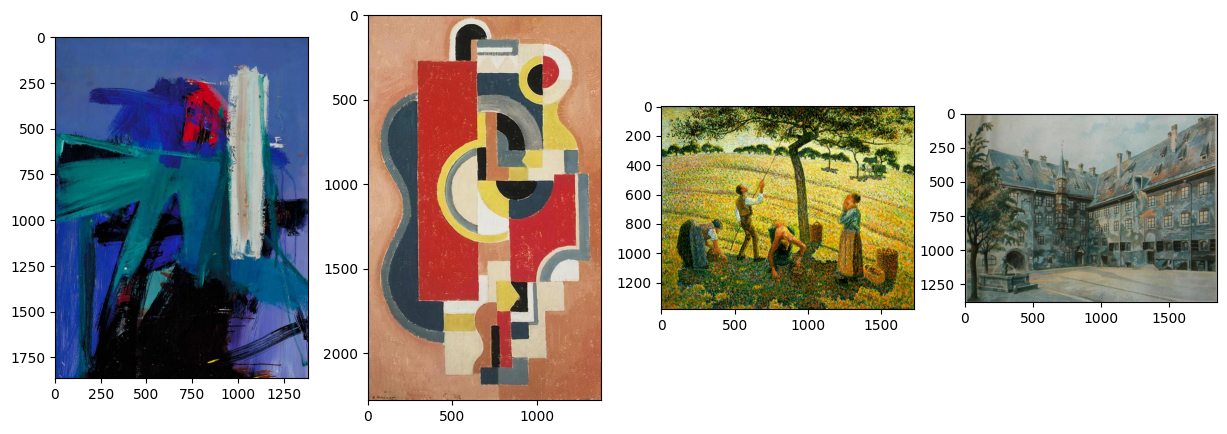

In [10]:
#Blueberry Eyes, Franz Kline (1960)
img1 = "img/franz-kline_blueberry-eyes-1960.jpg"
#Hommage à Delaunay et Gleizes, Adolf Fleischmann (1938)
img2 = "img/adolf-fleischmann_hommage-delaunay-et-gleizes-1938.jpg"
#Apple Picking at Eragny-sur-Epte, Camille Pissarro (1888)
img3 = "img/camille-pissarro_apple-picking-at-eragny-sur-epte-1888.jpg"
#The Courtyard of the Old Residency in Munich, Adolf Hitler (1914)
img4 = "img/adolf-hitler_the-courtyard-of-the-old-residency-in-munich-1913.jpg"

fig, ax = plt.subplots(1, 4, figsize=(15,5))
for i, imgpath in enumerate([img1, img2, img3, img4]):
    ax[i].imshow(io.imread(imgpath))

***

<span style="font-family:Cambria Math">

## Preprocesamiento

Para la construcción del pipeline de pre-procesamiento de los datos hay que considerar que estamos trabajando con imágenes. Por lo tanto, no se requiere quitar *outlayers*. También hay que tener en cuenta que, para el correcto funcionamiento de los modelos es recomendado tener los datos estandarizados para lo cual se usa `StandardScaler`. Sin embargo, por temas de organización el uso del estandarizador se va a dejar en las corridas del modelo.

También es necesario re-escalar las imágenes, esto permite un mejor uso de los recursos de procesamiento, ya que al final cada pixel se convertirá en un dato, por lo que se debe usar un número de píxeles adecuado que permita realizar la tarea de agrupación pero que no exija muchos recursos de cómputo. Nos aseguramos de mantener el rango de colores original que es lo que más nos interesa para efecto de la construcción de la paleta de colores, y se realiza un "suavizado" durante el escalado ya que cuando se reduce el tamaño de una imagen, se pueden tener efectos no deseados como el *aliasing* (escalones o bordes dentados). Con el parámetro `anti_aliasing=True` aplica un filtro de suavizado Gaussiano antes del escalado, reduciendo estos defectos.

</span>

In [12]:
# Downsampling
def reescalar_img(img: np.ndarray, factor: float):
    img_rescaled = rescale(
        img,
        scale=factor,
        channel_axis=2, #especificar cuál es el canal de colores
        order = 0, # Default
        anti_aliasing=True, #suavizar durante el escalado # Inicialmente: True
        preserve_range=True #mantener el rango de colores original
    )
    return img_rescaled.astype(img.dtype)

***
<span style="font-family:Cambria Math">

Se utiliza el comando `imread` de `skimage.io` para cargar la imagen y después de re-escalarla se hace la transformación de la imágen para tenerla en formato RGB y CIELAB

</span>

In [14]:
# Cargar img reescalada en ambos espacios de color: RGB y LAB
def cargar_img_RGB_LAB_downsample(imgpath: str, factor: float = 0.25):
    img = io.imread(imgpath)
    rgb = reescalar_img(img, factor)
    lab = color.rgb2lab(rgb)
    return img, rgb, lab

***
<span style="font-family:Cambria Math">

También es necesario re-estructurar los datos para poder trabajar los pixeles como filas y los canales como columnas:

</span>

In [15]:
# Obtener data tabular: pixeles como filas y CIELAB como columnas
def img_to_tabular(img: np.ndarray):
    return img.reshape(-1, img.shape[-1])

***
<span style="font-family:Cambria Math">

Se definen las funciones de estandarización y su respectiva inversa, para más adelante usarla en cada corrida del modelo. Esto se incorporará en el *pipeline* del modelo por facilidad.

</span>

In [16]:
def estandarizar(X: np.ndarray):
    scaler = StandardScaler()
    return scaler.fit_transform(X), scaler

In [17]:
def des_estandarizar(X: np.ndarray, scaler: object):
     return scaler.inverse_transform(X)

***
<span style="font-family:Cambria Math">

## Espacio de características RGB vs LAB

También consideramos importante tener una idea básica de la distribución de las características de los datos en el espacio 3D en RGB y en LAB

</span>

<img src="vid/clip.gif" width="750" align="center">

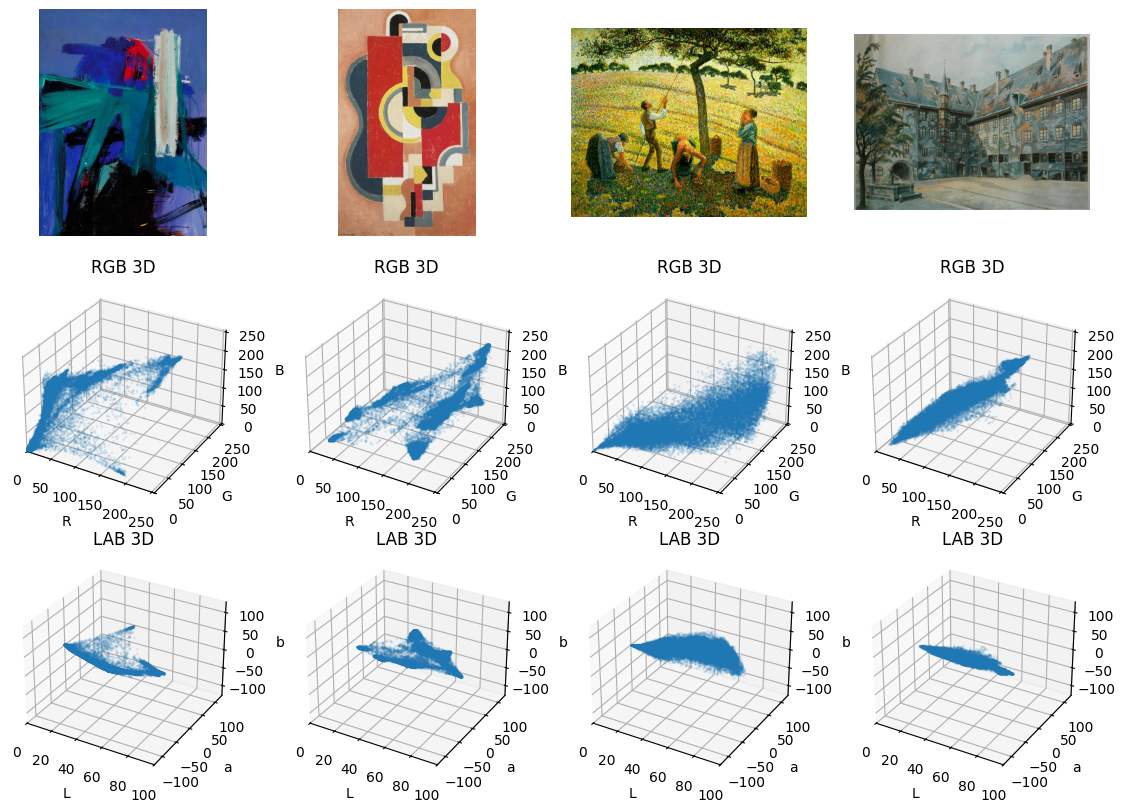

In [34]:
fig, ax = plt.subplots(3, 4, figsize=(14, 10))

for row in [1, 2]:
    for i in range(4):
        fig.delaxes(ax[row, i])
        pos = row * 4 + i + 1
        ax[row, i] = fig.add_subplot(3, 4, pos, projection='3d')

for i, imgpath in enumerate([img1, img2, img3, img4]):
    img, rgb, lab = cargar_img_RGB_LAB_downsample(imgpath, factor=0.10)
    
    ax[0, i].imshow(img)
    ax[0, i].axis('off')
    
    ax[1, i].scatter(*img_to_tabular(rgb).T, alpha=0.10, s=1)
    ax[1, i].set_title("RGB 3D")
    ax[1, i].set_xlim3d(left=0, right=255)
    ax[1, i].set_ylim3d(bottom=0, top=255) 
    ax[1, i].set_zlim3d(bottom=0, top=255)
    ax[1, i].set_xlabel("R")
    ax[1, i].set_ylabel("G")
    ax[1, i].set_zlabel("B")
    
    ax[2, i].scatter(*img_to_tabular(lab).T, alpha=0.10, s=1)
    ax[2, i].set_title("LAB 3D")
    ax[2, i].set_xlim3d(left=0, right=100)
    ax[2, i].set_ylim3d(bottom=-128, top=128) 
    ax[2, i].set_zlim3d(bottom=-128, top=128)
    ax[2, i].set_xlabel("L")
    ax[2, i].set_ylabel("a")
    ax[2, i].set_zlabel("b")

#plt.tight_layout()
#plt.show()

***
<span style="font-family:Cambria Math">

## Clustering

Para los modelos de agrupación se va a medir el *silhoutte score* de tres modelos: K-Medias (algoritmo basado en centroides), MeanShift (algoritmo híbrido),  Agrupación Aglomerativa (algoritmo jerárquico) y DBSCAN (algoritmo de densidad).

Se crean 4 funciones que nos permiten identificar los coeficientes de silueta de estos modelos pasando por un número de grupos entre 5 y 7 de acuerdo a las consideraciones del microproyecto (dependiendo de la particularidad de cada modelo ya que en algunos no se puede dar por parámetro el número de *clusters*).

</span>

***
<span style="font-family:Cambria Math">

## KMeans

</span>

In [21]:
# Selección de Kmeans con base en silhouette_score
def KMeans_silhouette(X: np.ndarray, Kmin: int = 5, Kmax: int = 7):
    # Estandarizar los datos
    X, scaler = estandarizar(X)

    # Ajuste de modelos en paralelo para mejorar velocidad
    def entrenar_kmeans(k):
        modelo = KMeans(n_clusters=k, max_iter=300, n_init="auto", random_state=42)
        labels = modelo.fit_predict(X)
        score = silhouette_score(X, labels)
        return modelo, score

    resultados = Parallel(n_jobs=-1)(
        delayed(entrenar_kmeans)(k) for k in range(Kmin, Kmax + 1)
    )

    # Obtener el mejor modelo basado en el Silhouette Score
    modelos, silhouette_scores = zip(*resultados)
    mejor_idx = np.argmax(silhouette_scores)
    mejor_modelo = modelos[mejor_idx]

    # Desestandarizar centroides
    centroides = des_estandarizar(mejor_modelo.cluster_centers_, scaler)
    centroids_RGB_img = color.lab2rgb(centroides).reshape((1, mejor_modelo.n_clusters, 3))
    centroides_no_reshape = color.lab2rgb(centroides)

    # Imprimir resultados
    for k, score in zip(range(Kmin, Kmax + 1), silhouette_scores):
        print(f"Modelo KMeans K={k} --> Silhouette Score: {score:.4f}")

    print("**Mejor modelo KMeans**")
    print(f"Número de clusters: {mejor_modelo.n_clusters}")

    return centroids_RGB_img, mejor_modelo.labels_, centroides_no_reshape

***
<span style="font-family:Cambria Math">

## MeanShift

</span>

In [22]:
# Definición de Función para la fase entrenamiento
def entrenar_meanshift(X, quantile):
    #Entrena un modelo MeanShift y devuelve el modelo, número de clusters y Silhouette Score
    bandwidth = estimate_bandwidth(X, quantile=quantile, n_samples=100)
    modelo = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    modelo.fit(X)
    n_clusters = len(modelo.cluster_centers_)

    # Evitar calcular silhouette_score si hay solo un cluster
    score = silhouette_score(X, modelo.labels_) if n_clusters > 1 else -1

    return modelo, n_clusters, quantile, score
# Selección de MeanShift con base en silhouette_score
def MeanShift_silhouette(X: np.ndarray, quantiles: list):
    # Estandarizar los datos
    X, scaler = estandarizar(X)

    # Paralelizar el entrenamiento de modelos
    resultados = Parallel(n_jobs=-1)(
        delayed(entrenar_meanshift)(X, q) for q in quantiles
    )

    # Extraer resultados
    modelos, clusters, quantiles_usados, silhouette_scores = zip(*resultados)

    # Mostrar resultados
    for k, q, score in zip(clusters, quantiles_usados, silhouette_scores):
        print(f"Modelo MeanShift K={k} Quantile={q} --> Silhouette Score: {score:.4f}")

    # Seleccionar el mejor modelo
    mejor_idx = np.argmax(silhouette_scores)
    mejor_modelo = modelos[mejor_idx]

    # Obtener centroides y convertirlos a RGB
    n = mejor_modelo.cluster_centers_.shape[0]
    centroides = des_estandarizar(mejor_modelo.cluster_centers_, scaler)
    centroids_RGB_img = color.lab2rgb(centroides).reshape((1, n, 3))
    centroides_no_reshape = color.lab2rgb(centroides)

    # Imprimir información del mejor modelo
    print("**Mejor modelo MeanShift**")
    print(f"Número de clusters: {n} Quantile={quantiles_usados[mejor_idx]}")

    return centroids_RGB_img, mejor_modelo.labels_, centroides_no_reshape

***
<span style="font-family:Cambria Math">

## DBSCAN

</span>

In [23]:
# Definición de Función para la fase entrenamiento
def entrenar_dbscan(X, eps, min_samples, metric):
    #Entrena DBSCAN y devuelve el modelo, número de clusters y Silhouette Score.
    modelo = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
    labels = modelo.fit_predict(X)

    # Filtrar ruido (-1) y calcular número de clusters reales
    unique_labels = np.unique(labels)
    num_clusters = len(unique_labels[unique_labels != -1])  # Excluir ruido

    # Evitar calcular silhouette_score si hay solo un cluster
    score = silhouette_score(X, labels) if num_clusters > 1 else -1

    return modelo, num_clusters, eps, min_samples, score
# Selección de DBSCAN con base en silhouette_score
def DBSCAN_silhouette(X: np.ndarray, eps_list: list, min_samples_list: list, metric: str ='euclidean'):
    # Estandarizar los datos
    X, scaler = estandarizar(X)

    # Paralelizar la búsqueda de hiperparámetros
    resultados = Parallel(n_jobs=-1)(
        delayed(entrenar_dbscan)(X, eps, min_samples, metric)
        for eps in eps_list for min_samples in min_samples_list
    )

    # Extraer resultados
    modelos, num_clusters, eps_values, min_samples_values, silhouette_scores = zip(*resultados)

    # Mostrar resultados
    for k, eps, min_samples, score in zip(num_clusters, eps_values, min_samples_values, silhouette_scores):
        print(f"Modelo DBSCAN K={k} Epsilon={eps} Min Samples={min_samples} --> Silhouette Score: {score:.4f}")

    # Seleccionar el mejor modelo
    mejor_idx = np.argmax(silhouette_scores)
    mejor_modelo = modelos[mejor_idx]
    mejor_eps = eps_values[mejor_idx]
    mejor_min_samples = min_samples_values[mejor_idx]

    # Obtener labels y filtrar ruido (-1)
    labels = mejor_modelo.labels_
    valid_labels = labels != -1  # Excluir puntos de ruido
    unique_labels = np.unique(labels[valid_labels])

    # Calcular "centroides" como el promedio de los core points por cluster
    centroids = np.array([X[labels == k].mean(axis=0) for k in unique_labels])
    centroids = des_estandarizar(centroids, scaler)

    # Convertir a imagen RGB
    mejor_k = len(centroids)
    centroids_RGB_img = color.lab2rgb(centroids).reshape((1, mejor_k, 3))
    centroides_no_reshape = color.lab2rgb(centroids)

    # Imprimir información del mejor modelo
    print("**Mejor modelo DBSCAN**")
    print(f"Número de clusters: {mejor_k} | Epsilon: {mejor_eps} | Min Samples: {mejor_min_samples}")

    return centroids_RGB_img, mejor_modelo.labels_, centroides_no_reshape

***
<span style="font-family:Cambria Math">

### Consideración para el algoritmo DBSCAN

Para el algoritmo de DBSCAN se prueban las heurísticas explicada en el curso para hallar tanto min_samples como eps. En nuestro caso el número de características del conjunto de datos es de 3 por lo que se aconseja un `min_samples` mayor o igual a 4. Cuando hay mucha dispersión este valor debería ser igual al doble del número de *features* razón por la cual se considerará más adelante probar min_samples entre 4 y 6.

</span>

In [24]:
# Función que permite hayar por heurística del Codo los mejores parámetros para eps en DBSCAN
def codo_DBSCAN(imagenes: list, min_samples: int):

  fig, ax = plt.subplots(1, len(imagenes), figsize=(15, 5))
  if len(imagenes) == 1:
        axes = [axes]

  else:

    for i, img in enumerate(imagenes):
      img, rgb, lab = cargar_img_RGB_LAB_downsample(img)
      lab_tabular = img_to_tabular(lab)

      KNN = NearestNeighbors(n_neighbors=min_samples).fit(lab_tabular)
      distancias, indices = KNN.kneighbors(lab_tabular)
      distancias = np.mean(distancias, axis=1)
      distancias = np.sort(distancias)


      # Detectar el codo con KneeLocator
      kneedle = KneeLocator(range(len(distancias)), distancias, curve="convex", direction="increasing")
      optimal_eps = distancias[kneedle.knee] if kneedle.knee else None  # Verifica si encontró el codo
      print("El codo en la figura",i+1,"es", optimal_eps )

      # Graficar la curva de distancias
      ax[i].plot(distancias)
      ax[i].set_xlabel("Índices de muestra ordenados")
      ax[i].set_ylabel(f"Distancia media al vecino más cercano")
      ax[i].set_title(f"Curva de distancias - Imagen {i+1}", fontsize=10)

      # Agregar línea horizontal punteada en el codo
      if optimal_eps:
          ax[i].axhline(y=optimal_eps, color='r', linestyle='--', linewidth=1.5)
          ax[i].text(len(distancias) * 0.7, optimal_eps, f"ε ≈ {optimal_eps:.3f}", color='r', fontsize=9)


  plt.tight_layout()
  plt.show()

El codo en la figura 1 es 2.472915191960247
El codo en la figura 2 es 1.933109913454312
El codo en la figura 3 es 2.4138947815474188
El codo en la figura 4 es 1.2427082421039504


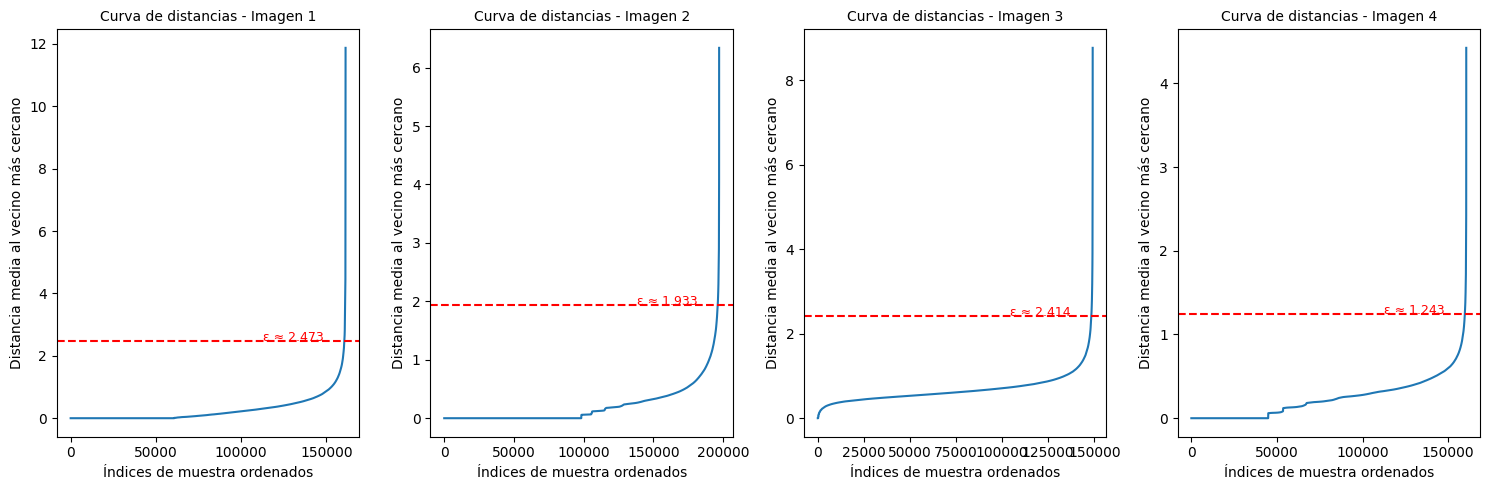

In [25]:
lista_pinturas =[img1, img2, img3, img4]
min_samples = 6
codo_DBSCAN(lista_pinturas, min_samples)

***
<span style="font-family:Cambria Math">

## HDBSCAN

</span>

In [27]:
# Entrena HDBSCAN y devuelve el modelo, número de clusters y Silhouette Score.

def entrenar_hdbscan(X: np.ndarray, min_samples):

    modelo = hdbscan.HDBSCAN(min_cluster_size=min_samples)
    labels = modelo.fit_predict(X)

    # Filtrar ruido (-1) y calcular número de clusters reales
    valid_labels = labels != -1  # Excluir puntos de ruido
    num_clusters = len(np.unique(labels[valid_labels]))

    # Evitar calcular silhouette_score si hay solo un cluster
    score = silhouette_score(X, labels) if num_clusters > 1 else -1

    return modelo, num_clusters, min_samples, score
# Selección de HDBSCAN con base en silhouette_score
def HDBSCAN_silhouette(X: np.ndarray, min_samples_list: list, metric: str ='euclidean'):
    # Estandarizar los datos
    X, scaler = estandarizar(X)

    # Paralelizar la búsqueda de hiperparámetros
    resultados = Parallel(n_jobs=-1)(
        delayed(entrenar_hdbscan)(X, min_samples) for min_samples in min_samples_list
    )

    # Extraer resultados
    modelos, num_clusters, min_samples_values, silhouette_scores = zip(*resultados)

    # Mostrar resultados
    for k, min_samples, score in zip(num_clusters, min_samples_values, silhouette_scores):
        print(f"Modelo HDBSCAN K={k} Min Samples={min_samples} --> Silhouette Score: {score:.4f}")

    # Seleccionar el mejor modelo
    mejor_idx = np.argmax(silhouette_scores)
    mejor_modelo = modelos[mejor_idx]
    mejor_min_samples = min_samples_values[mejor_idx]

    # Obtener labels y filtrar ruido (-1)
    labels = mejor_modelo.labels_
    valid_labels = labels != -1  # Excluir ruido
    unique_labels = np.unique(labels[valid_labels])

    # Calcular "centroides" como el promedio de los core points por cluster
    centroids = np.array([X[labels == k].mean(axis=0) for k in unique_labels])
    centroids = des_estandarizar(centroids, scaler)

    # Convertir a imagen RGB
    mejor_k = len(centroids)
    centroids_RGB_img = color.lab2rgb(centroids).reshape((1, mejor_k, 3))
    centroides_no_reshape = color.lab2rgb(centroids)

    # Imprimir información del mejor modelo
    print("**Mejor modelo HDBSCAN**")
    print(f"Número de clusters: {mejor_k} | Min Samples: {mejor_min_samples}")

    return centroids_RGB_img, mejor_modelo.labels_, centroides_no_reshape

***
<span style="font-family:Cambria Math">

## Aglomerativo

</span>

In [28]:
# Selección de AgglomerativeClusering con base en silhouette_score
def Agglomerative_silhouette(X: np.ndarray, Kmin: int = 5, Kmax: int = 7, link: str='ward'):

    modelos, silhouette_scores = (np.array([]),)*2
    X, scaler =  estandarizar(X)

    dlinkage = linkage(X, 'ward', 'euclidean') # (esta es una función de scipy)
    dendrogram(dlinkage)

    for i in range(Kmin, Kmax+1):
        modelo = AgglomerativeClustering(n_clusters=i, metric='euclidean', linkage=link)
        modelo.fit(X)
        modelos = np.append(modelos, modelo)
        silhouette_scores = np.append(silhouette_scores,silhouette_score(X, modelo.labels_))

    [print("Número de clusters:", i+Kmin, " --> Silhouette Score:", score) for (i,score) in enumerate(silhouette_scores)]

    mejor_modelo = modelos[silhouette_scores.argmax()]
    mejor_K = mejor_modelo.n_clusters_
    print(np.unique(mejor_modelo.labels_, return_counts=True))
    # centroides = des_estandarizar(mejor_modelo.cluster_centers_,scaler)
    # centroids_RGB_img = color.lab2rgb(centroides).reshape((1,mejor_K,3))
    # centroides_no_reshape = color.lab2rgb(centroides)
    # print("**Mejor modelo Agglomerative**")
    # print("Número de clusters:", mejor_K)
    #return centroids_RGB_img, mejor_modelo.labels_, centroides_no_reshape

Número de clusters: 5  --> Silhouette Score: 0.22083288805409926
Número de clusters: 6  --> Silhouette Score: 0.2517329630044254
Número de clusters: 7  --> Silhouette Score: 0.2942124377350492
(array([0, 1, 2, 3, 4, 5, 6]), array([2916,  196,  267,    2,   19, 1573, 1444]))
CPU times: user 12.6 s, sys: 3.55 s, total: 16.2 s
Wall time: 8.89 s


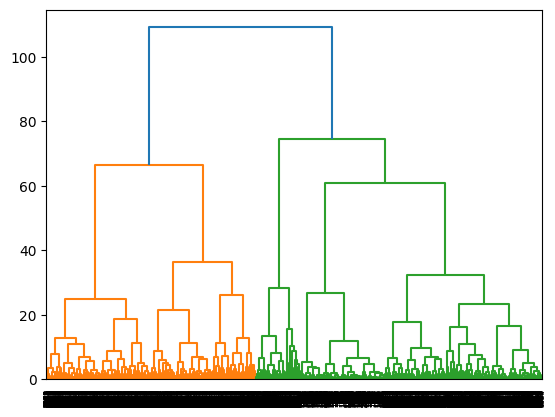

In [29]:
img, rgb_foo, lab_foo = cargar_img_RGB_LAB_downsample(img4, factor=0.05)
lab_foo_tabular = img_to_tabular(lab_foo)
%time Agglomerative_silhouette(lab_foo_tabular, link='average')

In [31]:
#%time Agglomerative_silhouette(lab_foo_tabular, link='ward')

***
<span style="font-family:Cambria Math">

## Visualización de rsultados

Una vez definidos los modelos sobre los que se va a probar cada pintura, se procede a correr los mejores representantes de cada modelo (escogidos por *score* de silueta) y se visualiza la representación de cada mejor agrupación en su versión en "Paleta", versión pixelada por cada color del centroide y finalmente con un gráfico en 2D utilizando t-SNE. Para facilidad de lectura del proyecto, se dejó el código con el parámetro del modelo con el mejor resultado.

</span>

## Paleta de colores + Visualización por Centroides + t-SNE

In [30]:
def generar_paleta(imgpath: str, factor:float = 0.05, modelo: str ='KMeans', tSNE : bool =False):
    img, rgb, lab = cargar_img_RGB_LAB_downsample(imgpath, factor=factor)
    lab_tabular = img_to_tabular(lab)

    if modelo == 'KMeans':
        paleta, labels, centers = KMeans_silhouette(lab_tabular)
    elif modelo == 'MeanShift':
        # Valores de Quantiles
        quan_list = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
        paleta, labels, centers = MeanShift_silhouette(lab_tabular,quan_list)
    elif modelo == 'DBSCAN':
        # Valores de Épsilon, se prueban un rango de los epsilons obtenidos anteriormente
        eps_list = [ 1.2, 1.5, 1.8, 2.1, 2.4]
        # Valores del mínimo de puntos
        min_samples_list = [4, 5, 6]
        paleta, labels, centers = DBSCAN_silhouette(lab_tabular, eps_list,min_samples_list)
    elif modelo == 'HDBSCAN':
        # Valores del mínimo de puntos
        min_samples_list = [4, 5, 6]
        paleta, labels, centers = HDBSCAN_silhouette(lab_tabular,min_samples_list)
    elif modelo == 'Aglomerativo':
        paleta, labels, centers = Agglomerative_silhouette(lab_tabular)
    else:
        print("Modelo no reconocido")

    # Imagen reescalada + Paleta
    if tSNE:
       fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    else:
       fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img)
    ax[1].imshow(paleta)

    # Imagen Pintada con los Colores de la Paleta
    img_segmented = centers[labels]
    img_segmented = img_segmented.reshape(rgb.shape)
    ax[2].imshow(img_segmented)

    print("Imagen reescalada a",str(rgb.shape[0])+"x"+str(rgb.shape[1]),"pixeles")

    if tSNE:
        # t-SNE

      pca = PCA(n_components=2)
      x_reduced = pca.fit_transform(lab_tabular)
      var_explicada = sum(pca.explained_variance_ratio_)
      tsne = TSNE(random_state=13, verbose=0)
      x_tsne = pd.DataFrame(tsne.fit_transform(x_reduced))

      markers = ['o', '^', 'v', 'd', 's', 'x', '+', '*', '_', '.']

      for i in range(len(centers)):
          selections = x_tsne.iloc[np.where(labels==i)]
          marker = markers[i % len(markers)]
          ax[3].scatter(selections[0], selections[1], alpha=0.8, marker=marker, s=5,c=centers[i])
          x_mean, y_mean = selections.mean(axis=0)
          ax[3].text(x_mean, y_mean, str(i), fontdict={'weight': 'bold', 'size': 20, 'color': (1-centers[i][0],1- centers[i][1],1- centers[i][2])})

    plt.tight_layout()
    plt.show()

/home/p300helios/CodeHub/python/pythonlab/venv2/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/p300helios/CodeHub/python/pythonlab/venv2/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/p300helios/CodeHub/python/pythonlab/venv2/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/p300helios/CodeHub/python/pythonlab/venv2/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/p300helios/CodeHub/python/pythonlab/venv2/lib/python3.13/site-pack

Modelo HDBSCAN K=721 Min Samples=4 --> Silhouette Score: -0.0940
Modelo HDBSCAN K=480 Min Samples=5 --> Silhouette Score: -0.1531
Modelo HDBSCAN K=352 Min Samples=6 --> Silhouette Score: -0.1504
**Mejor modelo HDBSCAN**
Número de clusters: 721 | Min Samples: 4
Imagen reescalada a 140x104 pixeles


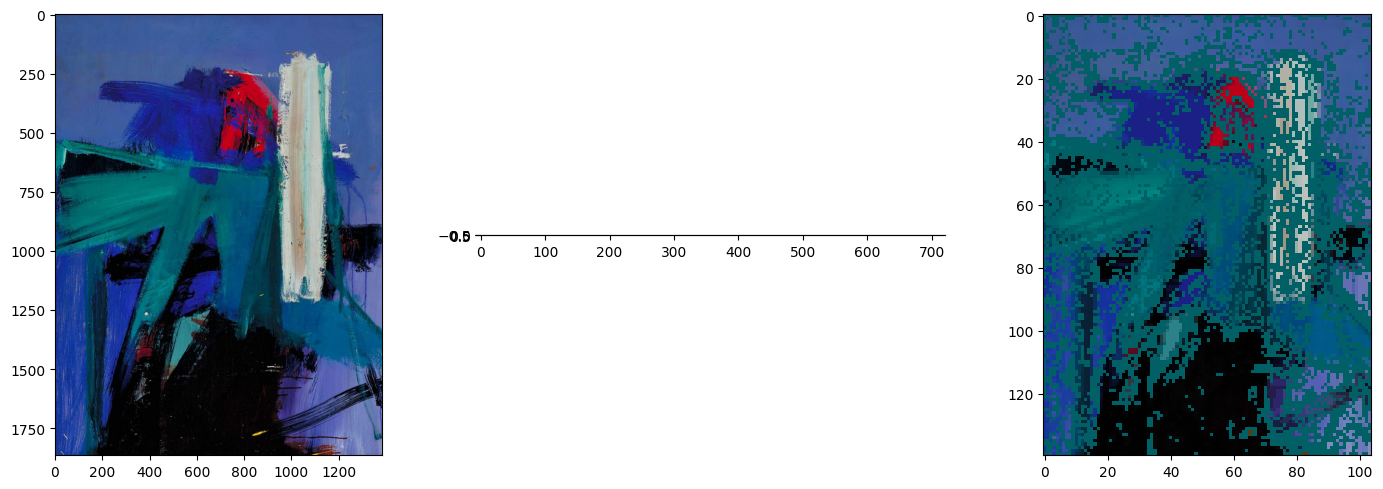

CPU times: user 823 ms, sys: 192 ms, total: 1.02 s
Wall time: 6.57 s


In [32]:
%time generar_paleta(img1, factor=0.075, modelo = "HDBSCAN", tSNE = False)

In [47]:
#%time generar_paleta(img2, factor=0.10, modelo = "KMeans", tSNE = False)

In [48]:
#%time generar_paleta(img3, factor=0.10, modelo = "KMeans", tSNE = False)

In [49]:
#%time generar_paleta(img4, factor=0.10, modelo = "KMeans", tSNE = False)

# Referencias

---
- https://en.wikipedia.org/wiki/CIELAB_color_space#Perceptual_differences
- https://es.wikipedia.org/wiki/Espacio_de_color_Lab
- https://scikit-image.org/docs/stable/api/skimage.color.html#skimage.color.rgb2lab
- https://stackoverflow.com/questions/52459146/what-should-be-the-input-to-skimage-color-rgb2lab